### Sales prediction
The data consists of sales data across different stores. The aim is to build a predictive model and find sales of different products. Also, the most important features which play a key role in driving sales have been explored.

Problem statement: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

In [2]:
### Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [10]:
## Dataset
data = pd.read_csv('../data/raw/Train.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [11]:
## Data statistics
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


The numerical variables have a huge variance and capture variability in sales well. Item Visibility has outliers as max visibility is 0.32 whereas as 75th percentile value is only 0.09.
This extreme behavior can be observed in case of outlet sales too with maximum sales being 13086 and 75th being just 3100.

In [12]:
#### Here another dataset can be created with data till 75th percentile and see how much data is lost
### After this decision to go ahead with original or transformed data can be taken
### Original dataset --> linear regression evaluation criteria can be changed from least squares to huber loss
### Transformed dataset --> Can perform linear regression

In [13]:
## Check for missing values
null_columns = data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

Item_Weight    1463
Outlet_Size    2410
dtype: int64

Missing values will be imputed after data exploration

In [21]:
###### Check for correlation among numerical variables
data.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


Item MRP and Sales show a high positive correlation as MRP increases, revenue generated from the product increases (could be due to high sales volume)

Also, item visibility share a small negative correlation with Sales.
-- This relation can be explored further (could be due to the MRP effect)
All other variables are uncorrelated with each other.

In [24]:
### How has sales changed over years
## Years data can be binned
### Can divide years into quartiles and see how sales vary in different groups
## 1985-1987, 1997-2002, 2004-2009

In [26]:
bins = [1985, 1997, 2004, 2009]
labels = ['1985-1987', '1997-2002', '2004-2009']
data['year_binned'] = pd.cut(data.Outlet_Establishment_Year, bins, labels = labels, include_lowest = True)

Text(0.5,1,'Item Outlet Sales across years')

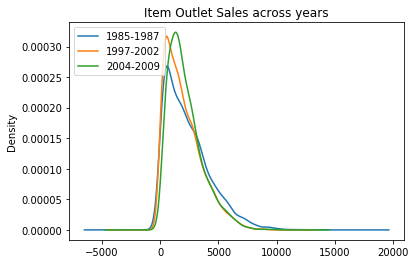

In [28]:
### Plot distribution functions to see how sales are distributed over each bin
## This is done to see if there are any major shifts in sales over years
data.groupby('year_binned').Item_Outlet_Sales.plot(kind='kde')
plt.legend(loc='upper left')
plt.title('Item Outlet Sales across years')

Sales have slightly increased over time (could be measured by rising MRP)

#### the data has been divided into store and item level attributes.

#### How do different store attributes drive sales?

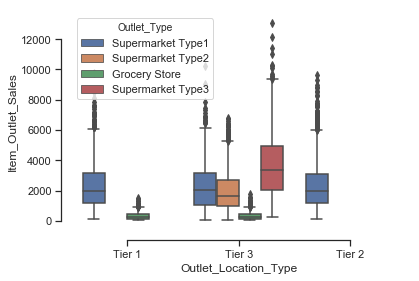

In [33]:
### How is sales influenced by outlet location and outlet type
sns.set(style="ticks")
sns.boxplot(x="Outlet_Location_Type", y="Item_Outlet_Sales", hue="Outlet_Type", data=data)
sns.despine(offset=10, trim=True)

Sales are highly influenced by Outlet Type. 

Grocery --> constant sales, not much variability

Supermarket type 3 --> accounts for maximum sales

In [34]:
### To see how outlet size affects sales
## missing values need to be imputed
## check outlet size attributes associated with outlet location and type
data.groupby(['Outlet_Location_Type','Outlet_Type','Outlet_Size'])['Outlet_Size'].count()

Outlet_Location_Type  Outlet_Type        Outlet_Size
Tier 1                Grocery Store      Small          528
                      Supermarket Type1  Medium         930
                                         Small          930
Tier 2                Supermarket Type1  Small          930
Tier 3                Supermarket Type1  High           932
                      Supermarket Type2  Medium         928
                      Supermarket Type3  Medium         935
Name: Outlet_Size, dtype: int64

In [39]:
## Check associated attributes for missing values in outlet size
data[data['Outlet_Size'].isnull()].groupby(['Outlet_Location_Type','Outlet_Type'])['Outlet_Location_Type'].count()

Outlet_Location_Type  Outlet_Type      
Tier 2                Supermarket Type1    1855
Tier 3                Grocery Store         555
Name: Outlet_Location_Type, dtype: int64

In [41]:
## Looking at associations above, outlet size can be replaced with small
data['Outlet_Size'].fillna('Small', inplace = True)

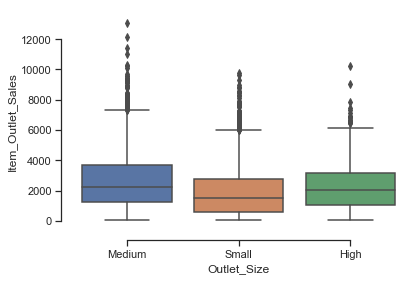

In [42]:
### How does Outlet Size affect Sales
sns.set(style="ticks")
sns.boxplot(x="Outlet_Size", y="Item_Outlet_Sales", data=data)
sns.despine(offset=10, trim=True)

Medium sized stores drive maximum sales, they have plenty of outliers too (should be treated in EDA though)

how do item level attributed impact sales?

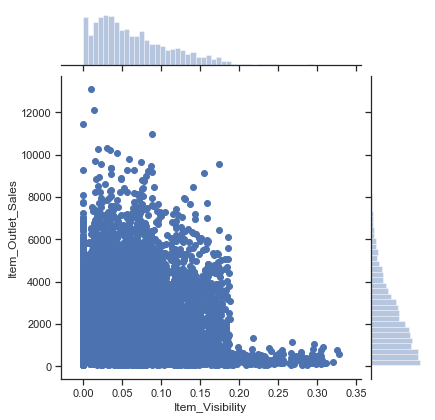

In [44]:
sns.jointplot(x="Item_Visibility", y="Item_Outlet_Sales", data=data);

In [45]:
### higher visibility have low sales?? (cheap products or low sales in volume)
### need to remove outliers

In [46]:
### Although MRP and visibility had no significant relationship.
### Hence lower sales could be due to lesser volume of products... reasons can be explored

In [47]:
### Item Weight does not affect sales as seen in correlation matrix
### Item Weight is a dense column with a high range of values
## Missing values can be imputed by mean weight
data['Item_Weight'].fillna(data['Item_Weight'].mean(),inplace = True)

In [50]:
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [49]:
## Data cleaning required
## LF, low fat --> Low Fat
## reg --> Regular
data['Item_Fat_Content'] = data['Item_Fat_Content'].map({'Low Fat': 'Low Fat','LF': 'Low Fat', 'low fat': 'Low Fat', 'reg' : 'Regular','Regular': 'Regular'})

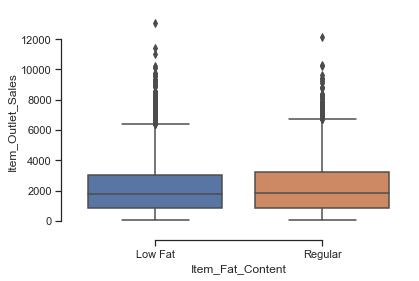

In [51]:
### How does Item Fat Content affect Sales
sns.set(style="ticks")
sns.boxplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=data)
sns.despine(offset=10, trim=True)

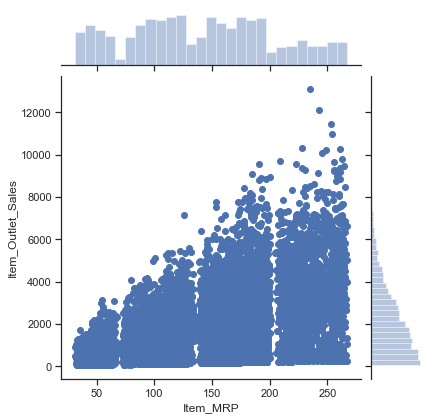

In [52]:
### How does mrp vary with item sales
sns.jointplot(x="Item_MRP", y="Item_Outlet_Sales", data=data);

In [53]:
### MRP and Outlet Sales have strong positive relation, as explored earlier

Hence, Outlet Type and Size effect highly influence store sales

Higher Visibility does not always indicate higher sales

Item with lower fat content have higher sales

In [54]:
### Item and outlet identifier increase dimensionality of data, can be dropped
data = data.drop(['Item_Identifier','Outlet_Identifier'],axis = 1)
data = data.drop(['year_binned'],axis = 1)

In [56]:
#### To confirm if the features obtained through data exploration significantly affect sales, we can perform feature
#### selection which recursively considers smaller and smaller set of features according to feature imp obtained
### by fitting in a linear model
from sklearn.feature_selection import RFE

In [67]:
data_dum = pd.get_dummies(data)
data_variables=data_dum.columns.values.tolist()
y=['Item_Outlet_Sales']
X=[i for i in data_variables if i not in y]
#### Feature selection
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
rfe = RFE(linreg, 15)
rfe = rfe.fit(data_dum[X], data_dum[y] )
print("Features sorted by their rank:")
feat = sorted(zip(map(lambda i: round(i, 4), rfe.ranking_), X))
df = pd.DataFrame(feat)
df.columns = ['rank','feature']
df.iloc[0:5]



C:\Users\lokesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features sorted by their rank:


,rank,feature
0,1,Item_Fat_Content_Regular
1,1,Item_Type_Canned
2,1,Item_Type_Dairy
3,1,Item_Type_Fruits and Vegetables
4,1,Item_Type_Household


In [75]:
### Certain Item types score highly and affect sales 
## Item visbility, Outlet Size, Outlet Type and MRP are among the most important features
### Subsetting dataframe to have most important features
featlist = df.iloc[0:23]['feature']
df_new = data_dum[featlist]
df_new['Item_Outlet_Sales'] = data_dum['Item_Outlet_Sales']

C:\Users\lokesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


A predictive model can be value adding as it can help the business know revenue generated from a product
This information can help them stock accordingly, this can help them increase revenue as they would know which products to target

In [77]:
### Model building with selected features from EDA and feature selection

In [78]:
### Build linear regression on selected features
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
linreg = LinearRegression()
scores = cross_val_score(linreg, df_new.drop('Item_Outlet_Sales',axis=1), df_new['Item_Outlet_Sales'], cv=5,scoring='mean_squared_error')
scores

C:\Users\lokesh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\lokesh\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\lokesh\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\lokesh\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: Deprec

array([-2359524.43399868, -2183495.33715369, -2063406.72825894,
       -2252154.13648826, -2227047.16486627])

In [79]:
print("RMSE:",np.mean(scores))

RMSE: -2217125.560153165


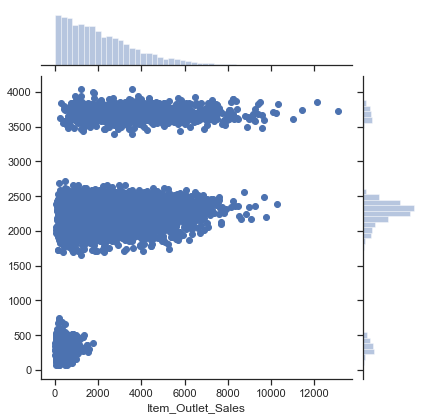

In [81]:
predicted = cross_val_predict(linreg, df_new.drop('Item_Outlet_Sales', axis=1), df_new['Item_Outlet_Sales'], cv=5)
sns.jointplot(x="Item_Outlet_Sales", y=predicted, data=df_new);

In [84]:
### Instead of RMSE, huber Loss can be used as evaluation criteria to see if outliers are adversely affecting model

### We can also plot residuals here and look at the pattern
## If interactions or polynomial curves fit the model better

### Can move towards PCA afterwards if there is no direct linear between variables
### After PCA, can run linear regression or polynomial on transformed variables

## Can move on to more complicated models to improve accuracy